# Cell Embedding Extraction and Visualization

This notebook demonstrates how to extract cell embeddings using Geneformer and visualize them.

## Contents:
1. Extract embeddings from tokenized data
2. UMAP visualization
3. 3D spatial visualization


In [1]:
import os
import scanpy as sc
import pandas as pd
from geneformer_utils import extract_embeddings, plot_3d_spatial


/home/wsg/software/miniconda3/envs/Geneformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration


In [ ]:
# Path configuration
MODEL_PATH = "/home/wsg/SSW/Geneformer/Geneformer-V2-316M/"
TOKEN_DATA_PATH = "/home/wsg/SSW/data/mouse_E9.5_heart/token/mouse_E9p5_heart.dataset"
OUTPUT_DIR = "/home/wsg/SSW/data/mouse_E9.5_heart/emb"
OUTPUT_PREFIX = "mouse_E9p5_heart"

# GPU configuration
GPU_ID = 3  # Set to None to use default GPU

# Embedding parameters
EMB_LABELS = ["organ", "cell_type", "n_counts"]  # Metadata columns to preserve
LABELS_TO_PLOT = ["cell_type"]  # Labels for default visualization

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [4]:
# 路径配置
MODEL_PATH = "/home/wsg/SSW/Geneformer/Geneformer-V2-316M/"
TOKEN_DATA_PATH = "/home/wsg/SSW/data/mouse_E11.5_heart/token/mouse_E11p5_heart.dataset"
OUTPUT_DIR = "/home/wsg/SSW/data/mouse_E11.5_heart/emb"
OUTPUT_PREFIX = "mouse_E11p5_heart"

# GPU配置
GPU_ID = 3  # 设为None使用默认GPU

# Embedding参数
EMB_LABELS = ["organ", "cell_type", "n_counts"]  # 要保留的元数据列
LABELS_TO_PLOT = ["cell_type"]  # 用于默认可视化的标签

os.makedirs(OUTPUT_DIR, exist_ok=True)


## 1. Extract Embeddings


In [5]:
embs = extract_embeddings(
    model_path=MODEL_PATH,
    token_data_path=TOKEN_DATA_PATH,
    output_dir=OUTPUT_DIR,
    output_prefix=OUTPUT_PREFIX,
    emb_labels=EMB_LABELS,
    labels_to_plot=LABELS_TO_PLOT,
    forward_batch_size=50,
    gpu_id=GPU_ID,
    nproc=16
)

print(f"\n✅ Embeddings extracted!")
print(f"Shape: {embs.shape}")
print(f"Columns: {list(embs.columns[:10])}...")  # 显示前10列


🎮 Using GPU 3
🚀 Extracting embeddings...


100%|██████████| 1980/1980 [18:19<00:00,  1.80it/s]


✅ Embeddings extracted! Shape: (98966, 1155)

✅ Embeddings extracted!
Shape: (98966, 1155)
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...


## 2. Construct AnnData Object for Analysis


In [ ]:
# Separate metadata and embedding data
metadata_cols = EMB_LABELS
emb_cols = [c for c in embs.columns if c not in metadata_cols and c != 'Unnamed: 0']

X_emb = embs[emb_cols].values
obs_meta = embs[metadata_cols]

adata_emb = sc.AnnData(X=X_emb, obs=obs_meta)

print(f"AnnData created: {adata_emb.n_obs} cells × {adata_emb.n_vars} dimensions")


AnnData created: 98966 cells × 1152 dimensions


/home/wsg/software/miniconda3/envs/Geneformer/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## 3. UMAP Visualization


Computing neighbors with cosine metric...
Computing UMAP...


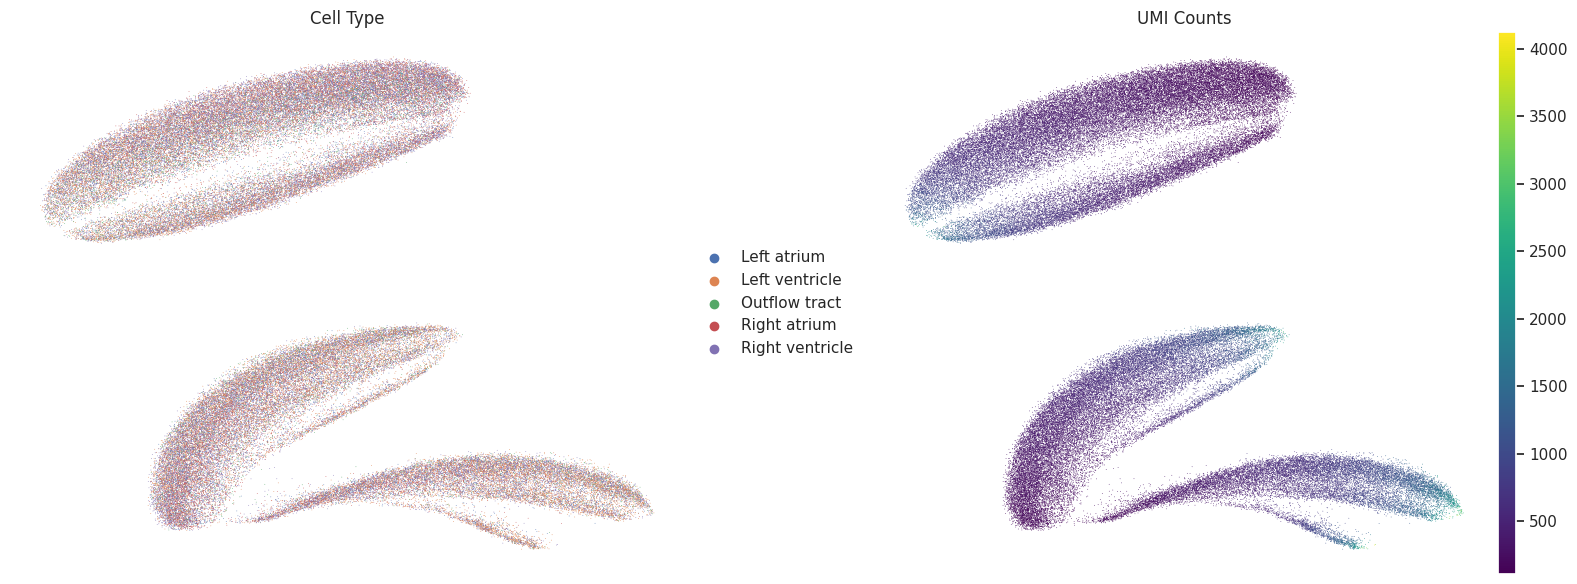

✅ UMAP saved to: figures/umap_mouse_E11p5_heart_cosine.pdf


In [ ]:
# Compute neighbors with cosine distance
print("Computing neighbors with cosine metric...")
sc.pp.neighbors(adata_emb, use_rep='X', metric='cosine', n_neighbors=30)

# Compute UMAP
print("Computing UMAP...")
sc.tl.umap(adata_emb, min_dist=0.3)

# Plot UMAP (optimized for documentation embedding)
import matplotlib.pyplot as plt

# Moderate figure size for document embedding
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: Cell Type (default colormap)
sc.pl.umap(
    adata_emb,
    color='cell_type',
    title='Cell Type',
    ax=axes[0],
    show=False,
    frameon=False
)

# Subplot 2: UMI Counts (viridis colormap)
sc.pl.umap(
    adata_emb,
    color='n_counts',
    title='UMI Counts',
    ax=axes[1],
    show=False,
    cmap='viridis',
    frameon=False
)

# Adjust layout to ensure legend visibility
plt.tight_layout()
plt.savefig(f"figures/umap_{OUTPUT_PREFIX}_cosine.png", dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ UMAP saved to: figures/umap_{OUTPUT_PREFIX}_cosine.png")


## 4. Remove Sequencing Depth Effect (Optional)


Removing n_counts effect using PCA regression...


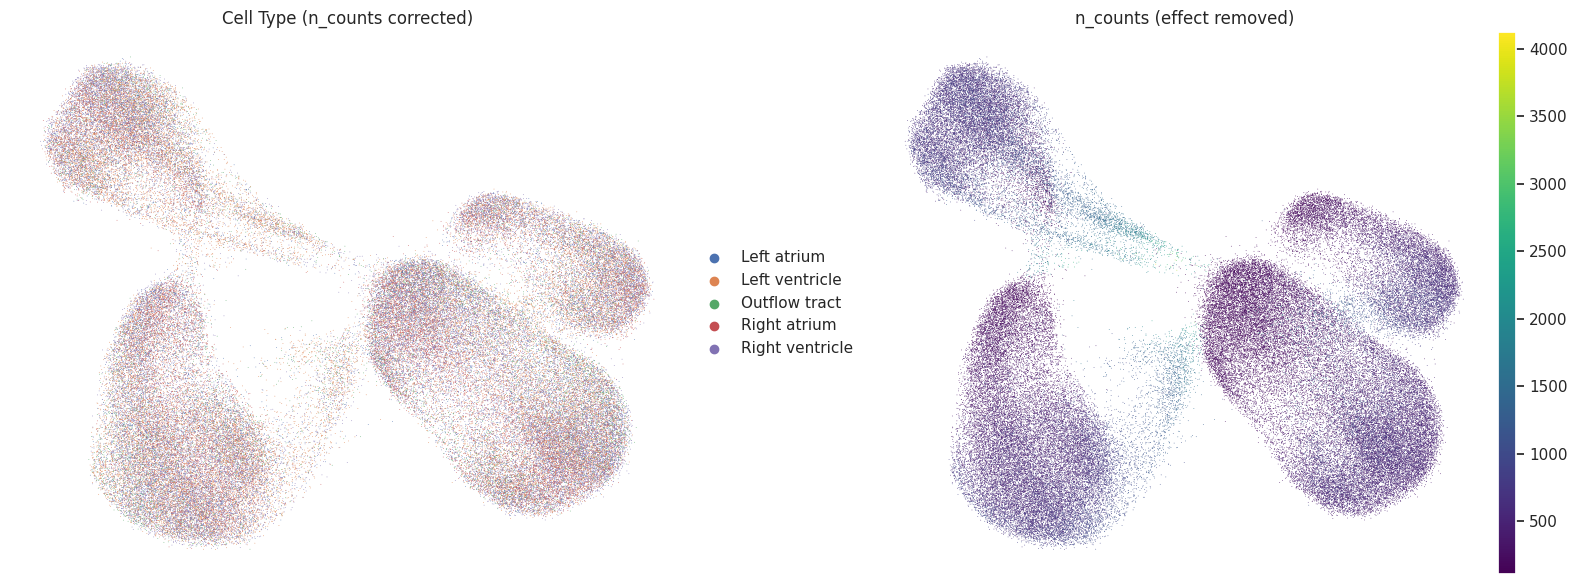

✅ Corrected UMAP saved to: figures/umap_mouse_E11p5_heart_corrected.pdf


In [ ]:
# Method 1: Regress out n_counts in PCA space
print("Removing n_counts effect using PCA regression...")
sc.tl.pca(adata_emb, n_comps=50)

# Perform regression in PCA space
adata_pca = sc.AnnData(X=adata_emb.obsm['X_pca'].copy(), obs=adata_emb.obs)
sc.pp.regress_out(adata_pca, keys=['n_counts'])
adata_emb.obsm['X_pca'] = adata_pca.X

# Compute UMAP based on corrected PCA
sc.pp.neighbors(adata_emb, use_rep='X_pca', metric='cosine', n_neighbors=30)
sc.tl.umap(adata_emb, min_dist=0.3)

# Plot corrected UMAP
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: Cell Type (corrected)
sc.pl.umap(
    adata_emb,
    color='cell_type',
    title='Cell Type (n_counts corrected)',
    ax=axes[0],
    show=False,
    frameon=False
)

# Subplot 2: n_counts (effect should be removed)
sc.pl.umap(
    adata_emb,
    color='n_counts',
    title='n_counts (effect removed)',
    ax=axes[1],
    show=False,
    cmap='viridis',
    frameon=False
)

plt.tight_layout()
plt.savefig(f"figures/umap_{OUTPUT_PREFIX}_corrected.png", dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ Corrected UMAP saved to: figures/umap_{OUTPUT_PREFIX}_corrected.png")


## 5. 3D Spatial Visualization (if spatial coordinates available)


In [ ]:
# Load original data to get spatial coordinates
adata_spatial = sc.read_h5ad("/home/wsg/SSW/data/mouse_E11.5_heart/mouse_E11.5_heart.h5ad")

if 'aligned_spatial_3D_new' in adata_spatial.obsm:
    print("Creating 3D spatial visualization...")
    
    fig = plot_3d_spatial(
        adata=adata_spatial,
        spatial_key='aligned_spatial_3D_new',
        color_by='heart_regions',
        save_path=f"{OUTPUT_DIR}/{OUTPUT_PREFIX}_3d_spatial.html",
        point_size=1.5,
        show_title=False  # Remove title for document embedding
    )
    
    fig.show(renderer="iframe")
else:
    print("No spatial coordinates found in data.")


Creating 3D spatial visualization...
✅ Plot saved to: /home/wsg/SSW/data/mouse_E11.5_heart/emb/mouse_E11p5_heart_3d_spatial.html


## Complete!

Embeddings have been extracted and visualized. Next steps:
- Cell type classification
- In silico perturbation analysis (see `03_in_silico_perturbation_optimized.ipynb`)
